In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential,load_model
from keras import layers,Input
from keras.losses import binary_crossentropy
from keras.layers import Dense
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
import keras.backend as K

2024-04-11 14:00:42.345640: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 14:00:42.962641: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 14:00:42.964983: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 14:00:45.016539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
state0_1,state1_1=np.load('../Data/ML/121623/state0_1.npy'),np.load('../Data/ML/121623/state1_1.npy')
# state0_2,state1_2=np.load('../Data/ML/121623/state0_2.npy'),np.load('../Data/ML/121623/state1_2.npy')
# state0_3,state1_3=np.load('../Data/ML/121623/state0_3.npy'),np.load('../Data/ML/121623/state1_3.npy')
output0=np.zeros((state0_1.shape[0]))
output1=np.ones((state1_1.shape[0]))
print(output0.shape,output1.shape)

(19150,) (19395,)


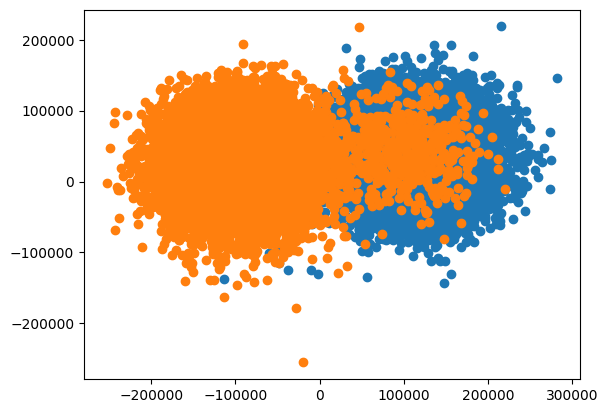

In [20]:
plt.scatter(state0_1[:,0],state0_1[:,1])
plt.scatter(state1_1[:,0],state1_1[:,1])

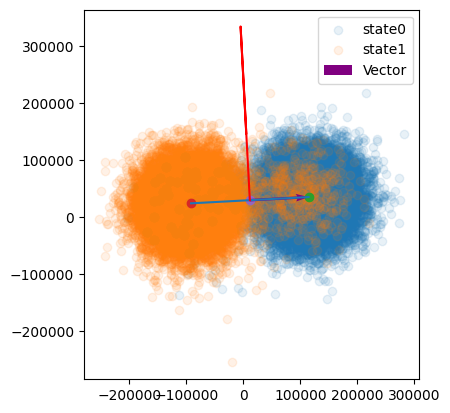

In [24]:
µ0=np.mean(state0_1,axis=0)
µ1=np.mean(state1_1,axis=0)
plt.scatter(state0_1[:,0],state0_1[:,1],alpha=0.1,label='state0')
plt.scatter(state1_1[:,0],state1_1[:,1],alpha=0.1,label='state1')
plt.scatter(µ0[0],µ0[1])
plt.scatter(µ1[0],µ1[1])

#Line
m=(µ1[1]-µ0[1])/(µ1[0]-µ0[0])
b=µ0[1]-(m*µ0[0])
plt.plot([µ0[0],µ1[0]],[µ0[1],µ1[1]])
center = [(µ1[0]+µ0[0])/2,(µ1[1]+µ0[1])/2]
plt.scatter(center[0],center[1])

#Orthogonal
mO=-1/m
bO=center[1]-(mO*center[0])
x1,x2=0.05e5,-0.05e5
y1,y2=(x1*mO)+bO,(x2*mO)+bO
plt.plot([x1,x2,center[0]],[y1,y2,center[1]],color='red')
plt.gca().set_aspect('equal', adjustable='box')

#Vector
vector_x = µ0[0]-center[0]
vector_y = µ0[1]-center[1]
vector=[vector_x,vector_y]
plt.quiver(center[0], center[1], vector_x, vector_y, angles='xy', scale_units='xy', scale=1, color='purple', label='Vector')
plt.legend()
plt.show()

In [31]:
count_gt,count_pr=0,0
for i in range(state0_1.shape[0]):
    if np.dot(vector,state0_1[i])>0:
        count_pr+=1
    count_gt+=1
print(count_pr/count_gt)

count_gt,count_pr=0,0
for i in range(state1_1.shape[0]):
    if np.dot(vector,state1_1[i])<0:
        count_pr+=1
    count_gt+=1
print(count_pr/count_gt)

0.9945169712793733
0.962619231760763


-9945116944.082737

In [6]:
# x=np.stack((np.vstack((state0_1,state1_1)),np.vstack((state0_2,state1_2)),np.vstack((state0_3,state1_3))),axis=2)
x=np.vstack((state0_1,state1_1))
print(x.shape)
y=np.hstack((output0,output1))
print(y.shape)

(38545, 2)
(38545,)


[1.13417899 0.8658729 ]
[0.56707478 0.43292522]
[0.56707478 1.        ]
X shape: (38545, 2)


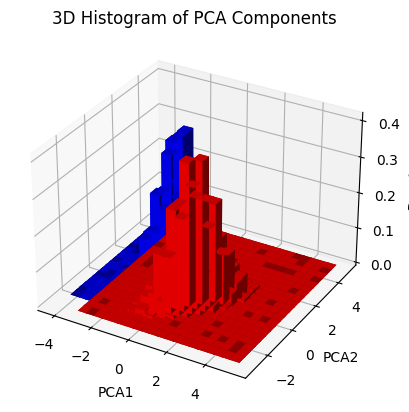

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
sc = StandardScaler()
X= sc.fit_transform(x)
# X_test = sc.transform(x_test)
pca = PCA(n_components = 2)
X = pca.fit_transform(X)
print (pca.explained_variance_)
print (pca.explained_variance_ratio_)
print (pca.explained_variance_ratio_.cumsum())
# X_test = pca.transform(X_test)
print("X shape: {}".format(X.shape))
x_red = X[y.ravel() == 1, :]  # for class '1'
x_blue = X[y.ravel() == 0, :]

# Create a histogram with two different colors
# plt.hist(x_blue, bins=50, color='blue', alpha=0.7, label='y=0')
# plt.hist(x_red, bins=50, color='red', alpha=0.7, label='y=1')
# # Add labels and legend
# plt.xlabel('Scaled values')
# plt.ylabel('Frequency')
# plt.legend()

# # Show the plot
# plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
hist, xedges, yedges = np.histogram2d(x_red[:, 0], x_red[:, 1], bins=20, density=True)
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='red', zsort='average')

# Repeat for the second class
hist, xedges, yedges = np.histogram2d(x_blue[:, 0], x_blue[:, 1], bins=20, density=True)
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='blue', zsort='average')

# Set labels and legend
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('Density')
plt.title('3D Histogram of PCA Components')
plt.show()


In [21]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.80, random_state=45)
# x1_train,x2_train,x3_train=x_train[:,:,0],x_train[:,:,1],x_train[:,:,2]
# x1_test,x2_test,x3_test=x_test[:,:,0],x_test[:,:,1],x_test[:,:,2]
# print(x1_train.shape,y_train.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=45)
print(x_train.shape)
print(y_train.sum())
print(x_train.shape)

classifier = LogisticRegression(random_state = 42, max_iter=500)
classifier.fit(x_train, y_train)
print(classifier.score(x_test,y_test))
pred1 = classifier.predict(x_test)

(30836, 2)
15473.0
(30836, 2)
0.9772992606044882


## Model1

In [5]:
classifier = LogisticRegression(random_state = 42, max_iter=500)
classifier.fit(x1_train, y_train)
print(classifier.score(x1_test,y_test))
pred1 = classifier.predict(x1_test)

0.9787585938513426


In [9]:
count=0
count1=0
for i in range(y_test.shape[0]):
    if y_test[i]==0:
        count+=1
        if pred1[i] == 0:
            count1+=1
print(count,count1)
print(count1/count)

count=0
count1=0
for i in range(y_test.shape[0]):
    if y_test[i]==1:
        count+=1
        if (pred1[i]) ==1:
            count1+=1
print(count,count1)
print(count1/count)

15372 15262
0.9928441321883945
15464 14919
0.9647568546301086


## Model2

In [6]:
classifier = LogisticRegression(random_state = 42, max_iter=500)
classifier.fit(x2_train, y_train)
print(classifier.score(x2_test,y_test))
pred2 = classifier.predict(x2_test)

0.957809054352056


In [10]:
count=0
count1=0
for i in range(y_test.shape[0]):
    if y_test[i]==0:
        count+=1
        if pred2[i] == 0:
            count1+=1
print(count,count1)
print(count1/count)

count=0
count1=0
for i in range(y_test.shape[0]):
    if y_test[i]==1:
        count+=1
        if (pred2[i]) ==1:
            count1+=1
print(count,count1)
print(count1/count)

15372 15257
0.9925188654696852
15464 14278
0.923305742369374


## Model3

In [7]:
classifier = LogisticRegression(random_state = 42, max_iter=500)
classifier.fit(x3_train, y_train)
print(classifier.score(x3_test,y_test))
pred3 = classifier.predict(x3_test)

0.937216240757556


In [11]:
count=0
count1=0
for i in range(y_test.shape[0]):
    if y_test[i]==0:
        count+=1
        if pred3[i] == 0:
            count1+=1
print(count,count1)
print(count1/count)

count=0
count1=0
for i in range(y_test.shape[0]):
    if y_test[i]==1:
        count+=1
        if (pred3[i]) ==1:
            count1+=1
print(count,count1)
print(count1/count)

15372 15247
0.9918683320322664
15464 13653
0.8828892912571132


## Majority Voting

In [8]:
count=0
count1=0
for i in range(y_test.shape[0]):
    if y_test[i]==0:
        count+=1
        if (pred1[i] + pred2[i] + pred3[i]) < 2:
            count1+=1
print(count,count1)
print(count1/count)

count=0
count1=0
for i in range(y_test.shape[0]):
    if y_test[i]==1:
        count+=1
        if (pred1[i] + pred2[i] + pred3[i]) >=2:
            count1+=1
print(count,count1)
print(count1/count)

15372 15321
0.9966822794691648
15464 14329
0.9266037247801345
